In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx 
import osmnx as ox

from geopy.distance import great_circle

pd.set_option('display.max_columns', None)

In [2]:
G_road = nx.read_gpickle('data/road_G.plk')

G_rail = nx.read_gpickle('data/rail_G.plk')

In [3]:
road_nodes,road_edges = ox.graph_to_gdfs(G_road)

rail_nodes,rail_edges = ox.graph_to_gdfs(G_rail)

In [4]:
road_edges.head(2)

,STATUS,trans_mode,length,duration_h,CO2_eq_kg,geometry,u,v,key
0,1,road,1909.0,0.016894,0.000001,"LINESTRING (-81.07680 29.26320, -81.07690 29.2...",1000010339,1000011514,0
1,1,road,2168.0,0.019186,0.000002,"LINESTRING (-81.07680 29.26320, -81.06440 29.2...",1000010339,1000011559,0


In [5]:
road_nodes.head(2)

,trans_mode,x,y,osmid,geometry,key
1000010339,road,-81.0768,29.2632,"(-81.0768, 29.2632)",POINT (-81.07680 29.26320),0
1000002476,road,-82.1339,27.0072,"(-82.1339, 27.0072)",POINT (-82.13390 27.00720),0


In [6]:
road_edges.head(2)

,STATUS,trans_mode,length,duration_h,CO2_eq_kg,geometry,u,v,key
0,1,road,1909.0,0.016894,0.000001,"LINESTRING (-81.07680 29.26320, -81.07690 29.2...",1000010339,1000011514,0
1,1,road,2168.0,0.019186,0.000002,"LINESTRING (-81.07680 29.26320, -81.06440 29.2...",1000010339,1000011559,0


In [7]:
rail_edges.head(2)

,OBJECTID,FRAARCID,STFIPS,RROWNER1,TRACKS,DIRECTION,NET,TIMEZONE,trans_mode,length,CO2_eq_kg,speed_kmh,duration_h,geometry,STRACNET,IM_RT_TYPE,DS,TRKRGHTS1,PASSNGR,TRKRGHTS2,TRKRGHTS3,u,v,key
0,178376,476815,01,AGR,1,2.0,M,C,rail,3085.42343,4.182919e-08,16,0.133893,"LINESTRING (-87.49830 30.99790, -87.49700 31.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,416132,88,0
1,"[178170, 178171, 178173, 178166]","[476609, 476610, 476612, 476605]",12,AGR,1,2.0,M,C,rail,37397.95557,6.717022e-06,16,21.500911,"LINESTRING (-87.43640 30.68880, -87.50610 30.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,416132,416709,0


It can be observed that the columns `RROWNER2`, `TRKRGHTS4` have been removed. This is because all their values were null (only florida)

In [8]:
def map_intermodal_to_road(road_nodes,rail_nodes):
    
    intermodal_rail_nodes = rail_nodes[rail_nodes.trans_mode == 'intermodal']

    df = pd.DataFrame(index = intermodal_rail_nodes.index,columns=['road_idx','dist'])
    
    for row in intermodal_rail_nodes.itertuples():
        dist = pd.eval('(road_nodes.x-row.x)**2 + (road_nodes.y-row.y)**2')
        df.loc[row.Index,'road_idx'] = dist.idxmin()
        df.loc[row.Index,'dist'] = great_circle((row.x,row.y),(road_nodes.loc[dist.idxmin(),'x'],road_nodes.loc[dist.idxmin(),'y'])).km * 1000
    return df

intermodal_to_road_map = map_intermodal_to_road(road_nodes,rail_nodes)

intermodal_to_road_map

,road_idx,dist
88,1000014898,865.138
111,1000014921,1666.48
131,1000014933,4372.02
175,1000015121,511.322
45,1000015110,2476.96
170,1000014980,126.96
171,1000015133,1616.61
84,1000013829,472.642
85,1000014153,158.671
153,1000014801,2245.39


In [9]:
intermodal_links = pd.DataFrame(index = range(len(intermodal_to_road_map)),columns=road_edges.columns)
kg_co2_per_tkm=0.080513
i = 0
for row in intermodal_to_road_map.itertuples():
    intermodal_links.loc[i,'u'] = row.road_idx
    intermodal_links.loc[i,'v'] = row.Index
    intermodal_links.loc[i,'length'] = row.dist
    intermodal_links.loc[i,'speed_kmh'] = 10 #DEFAULT
    intermodal_links.loc[i,'duration_h'] = 2 #Hours DEFAULT
    intermodal_links.loc[i,'CO2_eq_kg'] = intermodal_links.loc[i,'length']/1000 * kg_co2_per_tkm
    intermodal_links.loc[i,'key'] = 0
    intermodal_links.loc[i,'trans_mode'] = 'intermodal_link'
    i+=1
    
intermodal_links

,STATUS,trans_mode,length,duration_h,CO2_eq_kg,geometry,u,v,key,speed_kmh
0,NaN,intermodal_link,865.138,2,0.0696548,NaN,1000014898,88,0,10.0
1,NaN,intermodal_link,1666.48,2,0.134174,NaN,1000014921,111,0,10.0
2,NaN,intermodal_link,4372.02,2,0.352004,NaN,1000014933,131,0,10.0
3,NaN,intermodal_link,511.322,2,0.0411681,NaN,1000015121,175,0,10.0
4,NaN,intermodal_link,2476.96,2,0.199428,NaN,1000015110,45,0,10.0
5,NaN,intermodal_link,126.96,2,0.0102219,NaN,1000014980,170,0,10.0
6,NaN,intermodal_link,1616.61,2,0.130158,NaN,1000015133,171,0,10.0
7,NaN,intermodal_link,472.642,2,0.0380538,NaN,1000013829,84,0,10.0
8,NaN,intermodal_link,158.671,2,0.0127751,NaN,1000014153,85,0,10.0
9,NaN,intermodal_link,2245.39,2,0.180783,NaN,1000014801,153,0,10.0


In [10]:
road_edges = road_edges.append(intermodal_links,ignore_index=True)

In [11]:
intermodal_nodes = pd.DataFrame(index = intermodal_to_road_map.index,columns=road_nodes.columns)

for row in intermodal_to_road_map.itertuples():
    intermodal_nodes.loc[row.Index,'x'] = rail_nodes.loc[row.Index,'x']
    intermodal_nodes.loc[row.Index,'y'] = rail_nodes.loc[row.Index,'y']
    intermodal_nodes.loc[row.Index,'geometry'] = rail_nodes.loc[row.Index,'geometry']
    intermodal_nodes.loc[row.Index,'STCYFIPS'] = rail_nodes.loc[row.Index,'STCYFIPS']

    
intermodal_nodes['trans_mode'] = 'intermodal'
intermodal_nodes['key'] = 0

In [12]:
intermodal_nodes

,trans_mode,x,y,osmid,geometry,key,STCYFIPS
88,intermodal,-87.497,31.0255,NaN,POINT (-87.497 31.0255),0,01053
111,intermodal,-85.393,31.0364,NaN,POINT (-85.393 31.0364),0,01069
131,intermodal,-84.6651,31.0682,NaN,POINT (-84.6651 31.0682),0,13201
175,intermodal,-83.3872,31.0295,NaN,POINT (-83.38720000000001 31.0295),0,13075
45,intermodal,-82.7826,31.0222,NaN,POINT (-82.7826 31.0222),0,13065
170,intermodal,-82.3816,27.9613,NaN,POINT (-82.38160000000001 27.9613),0,12057
171,intermodal,-82.0153,31.065,NaN,POINT (-82.0153 31.065),0,13049
84,intermodal,-81.7689,30.3854,NaN,POINT (-81.7689 30.3854),0,12031
85,intermodal,-81.732,30.3696,NaN,POINT (-81.732 30.3696),0,12031
153,intermodal,-81.707,30.8776,NaN,POINT (-81.70699999999999 30.8776),0,13039


In [14]:
road_nodes  = road_nodes.append(intermodal_nodes)

In [15]:
G_road_w_link = ox.graph_from_gdfs(road_nodes, road_edges)

In [16]:
multimodal_net = nx.compose(G_road_w_link,G_rail)

In [17]:
nodes, edges = ox.graph_to_gdfs(multimodal_net)

In [18]:
nodes.loc[68,:]

trans_mode                           intermodal
x                                      -80.1299
y                                        26.082
osmid                                       NaN
geometry      POINT (-80.12990000000001 26.082)
key                                           0
STCYFIPS                                  12011
FRANODEID                                    68
STATE                                        FL
Name: 68, dtype: object

Text(0.5, 1.0, 'connected components size')

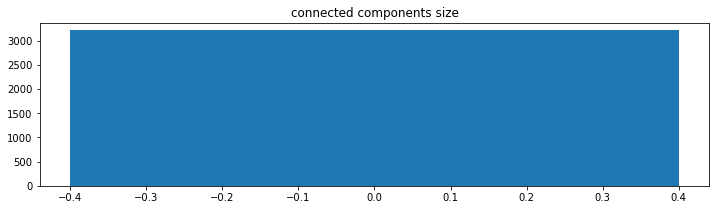

In [19]:
import matplotlib.pyplot as plt
multimodal_net_u = multimodal_net.to_undirected()

component_size = sorted([len(component) for component in nx.connected_components(multimodal_net_u)], reverse=True)
fig, ax = plt.subplots(figsize=(12,3))
plt.bar(range(len(component_size)),component_size)
plt.plot(range(len(component_size)),component_size,color='red',alpha=0.5)
plt.title('connected components size')

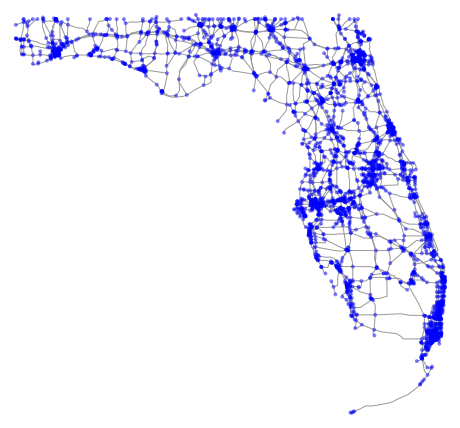

In [20]:
fig, ax = ox.plot_graph(multimodal_net_u,node_color='blue',bgcolor='white',node_alpha=0.5)

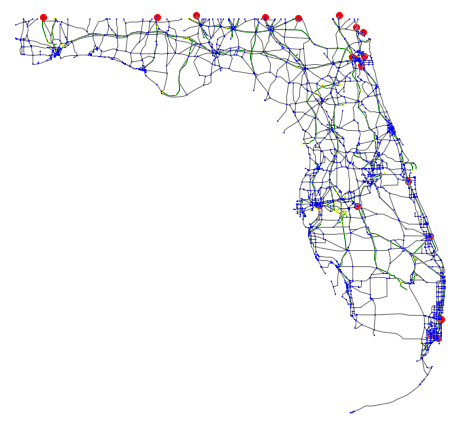

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [39]:
fig, ax = ox.plot_graph(G_rail,edge_color="green",node_color='yellow',bgcolor='white',node_size=2, node_alpha=0.9,show=False)
rail_nodes[rail_nodes.trans_mode == 'intermodal'].plot(ax=ax, color='red')
ox.plot_graph(G_road_w_link,edge_color="grey", node_color='blue',bgcolor='white',node_size=2, node_alpha=0.9,show=True,ax=ax)

# Routing

In [51]:
def get_route(G,orig,dest,weight='duration_h',orig_dest_size=100,algo='astar'):
    
    node_orig,dist_orig = ox.distance.get_nearest_node(G, orig, method='haversine', return_dist=True)
    node_dest,dist_dest = ox.distance.get_nearest_node(G, dest, method='haversine', return_dist=True)
    
    if algo == 'astar':
        dist_path = nx.astar_path_length(G, node_orig, node_dest, weight='length')
        weight_path = nx.astar_path_length(G, node_orig, node_dest, weight=weight)
        shortest_path_nx = nx.astar_path(G, node_orig, node_dest, weight=weight)
        
    elif algo == 'dijkstra':
        dist_path = nx.dijkstra_path_length(G, node_orig, node_dest, weight='length')
        weight_path = nx.dijkstra_path_length(G, node_orig, node_dest, weight=weight)
        shortest_path_nx = nx.dijkstra_path(G, node_orig, node_dest, weight=weight)
        
    else:
        raise AssertionError(f'The parameter "algo" can either be "astar" or "dijkstra", not {algo}')
    
    distance_highway = dist_path
    
    dist_non_highway = dist_orig + dist_dest
    
    total_dist =  dist_non_highway + distance_highway
    
    fig, ax = plt.subplots(figsize=(15, 7))
   
    ax.scatter(orig[1],orig[0],marker='x',s=orig_dest_size,zorder=5)
    ax.scatter(dest[1],dest[0],marker='x',s=orig_dest_size,zorder=10)
    ox.plot_graph(G, edge_color="#bfbfbf", node_color="#595959",bgcolor="w",ax=ax, show=False)
    ox.plot.plot_graph_route(G, shortest_path_nx, route_color='g', route_linewidth=4, route_alpha=0.9, orig_dest_size=100,ax=ax)
    
    if weight=='length':
        
        print(f'Distance {dist_path/1000} [km]')
        
    if weight=='duration_h':
        if dist_path>1:
            print(f'Duration {weight_path} [h] \nDistance {total_dist/1000} [km]')
            
        else:
            print(f'Duration {weight_path*60} [min] \nDistance {total_dist/1000} [km]')
    
    else:
        print(f'{str(weight)}: {dist_path/1000}')
        
    return node_orig, node_dest

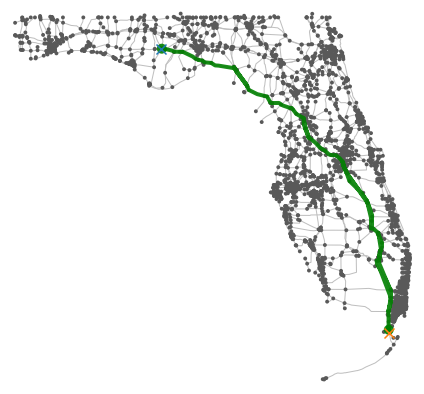

Distance 846.862 [km]
length: 846.862


(1000001567, 1000006518)

In [52]:
hwy_dest = (25.382380, -80.475159)
hwy_ori =(30.439440, -85.057166)

get_route(multimodal_net_u,hwy_ori,hwy_dest,weight='length')

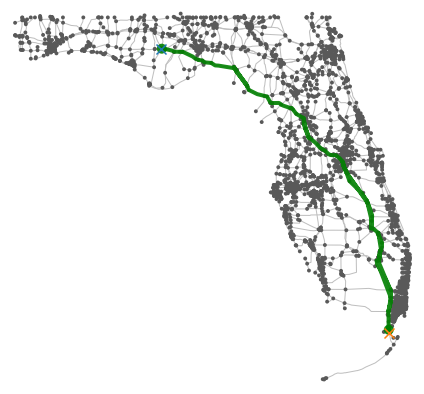

Duration 7.494353982300884 [h] 
Distance 853.9138958970499 [km]


(1000001567, 1000006518)

In [53]:
get_route(multimodal_net_u,hwy_ori,hwy_dest,weight='duration_h')

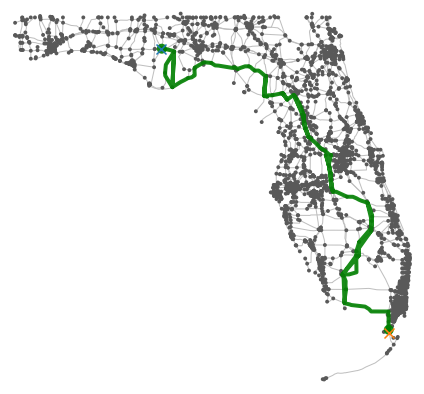

co2_equ_kg: 846.862


(1000001567, 1000006518)

In [54]:
get_route(multimodal_net_u,hwy_ori,hwy_dest,weight='co2_equ_kg')